### **NOTE**

The following code was **adopted from the TensorFlow implementation** of LOCALS to enable the development of **LOCALS-Multi** (multiple LaSOs per image).
LOCALS-Multi retrains a model originally trained with **LOCALS-Single** (single LaSO per image) to achieve improved performance. **LOCALS-Multi has not yet been implemented and will be in the future.**

Due to this inheritance from the TensorFlow implementation, the **dataset format** used in LOCALS-Single follows the TensorFlow convention:

$$
\textbf{TensorFlow format: } [\text{Batch (B)}, \text{Height (H)}, \text{Width (W)}, \text{Channels (C)}]
$$

However, PyTorch uses a different convention:

$$
\textbf{PyTorch format: } [\text{Batch (B)}, \text{Channels (C)}, \text{Height (H)}, \text{Width (W)}]
$$

As a result, the code includes the use of **`torch.permute()`** to **rearrange tensor dimensions** and ensure compatibility with PyTorch’s expected input format.

```python
# Example: Convert from NHWC (TensorFlow) to NCHW (PyTorch)
inputs = inputs.permute(0, 3, 1, 2)  # (B, H, W, C) → (B, C, H, W)
```

This conversion is **crucial for proper model training and inference** within the PyTorch framework.


# Imports

In [ ]:
# standard library
import os
import pickle

# third party libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm

In [ ]:
batch_size = 1
os.makedirs('figures', exist_ok=True)

# Model

In [3]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.model = nn.Sequential(
            # first block
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.LayerNorm([64, 240, 240]),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # second block
            nn.Conv2d(64, 192, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.LayerNorm([192, 60, 60]),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # third block
            nn.Conv2d(192, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.LayerNorm([256, 30, 30]),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.LayerNorm([512, 30, 30]),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # fourth block
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.LayerNorm([512, 15, 15]),
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.LayerNorm([1024, 8, 8]),

            # final block
            nn.Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.LayerNorm([1024, 4, 4])
        )

        # manually initialize all Conv2d layers' weights with He Normal (Kaiming Normal)
        for m in self.model:
            if isinstance(m, nn.Conv2d): # if layer is a conv layer
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') # initialize weights with He Normal
                if m.bias is not None: # initialize bias with zeros
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.model(x)

In [4]:
class ProtoModel(nn.Module):
    def __init__(self):
        super(ProtoModel, self).__init__()
        self.feature_extractor = FeatureExtractor()  # from earlier
        
        # the output from the extractor is [batch, 1024, 4, 4], flatten it
        self.flatten = nn.Flatten()

        # dense layer, output shape is [batch, 147]
        self.fc = nn.Linear(in_features=1024 * 4 * 4, out_features=7 * 7 * 3)

        # sigmoid activation for output normalization
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.feature_extractor(x)             # [batch, 1024, 4, 4]
        x = self.flatten(x)                       # [batch, 1024*4*4]
        x = self.fc(x)                            # [batch, 147]
        x = self.activation(x)                    # [batch, 147]
        x = x.view(-1, 7, 7, 3)                   # Reshape to [batch, 7, 7, 3]
        return x

# Loss Function

In [ ]:
def locals_loss(beta=5.0, gamma=5.0):  
    '''
    beta: weight for localization loss
    gamma: weight for objectness loss
    '''

    def binary_focal_loss(pred, target, alpha=0.25, gamma=2.0, eps=1e-8):
        pred = pred.clamp(eps, 1.0 - eps)  # avoid log(0)
        # compute p_t
        p_t = pred * target + (1 - pred) * (1 - target)
        alpha_t = alpha * target + (1 - alpha) * (1 - target)
        loss = - alpha_t * (1 - p_t) ** gamma * torch.log(p_t)
        return loss.mean()

    def focal_localization_loss(pred_coords, true_coords, mask, alpha=0.25, gamma=2.0, eps=1e-8):
        d = torch.sqrt(torch.sum((pred_coords - true_coords) ** 2, dim=-1))
        pt = 1 - torch.sigmoid(20 * (d - 0.1))
        pt = pt.clamp(eps, 1.0 - eps)
        loss = - alpha * (1 - pt) ** gamma * mask * torch.log(pt)
        
        return (loss).sum() / mask.sum()
        
    # actual loss function
    def loss_func(predicted, true):
        # goal is to sum each loss for each prediction in each batch
        loc_loss = 0
        obj_loss = 0
        
        # iterate through each image in the batch
        for i in range(batch_size):
            ith_predicted = predicted[i]
            ith_true = true[i]

            obj_mask = ith_true[..., 2]
            true_coordinates = ith_true[..., :2]

            obj_pred = ith_predicted[..., 2]
            pred_coordinates = ith_predicted[..., :2]

            # find localization loss
            loc_loss += focal_localization_loss(pred_coordinates, true_coordinates, obj_mask)

            # find objectness loss
            ith_obj_loss = binary_focal_loss(obj_pred, obj_mask)
            obj_loss += ith_obj_loss

        # first find mean loss
        loc_loss /= batch_size
        obj_loss /= batch_size

        # then find total loss
        total_loss = beta * loc_loss + gamma * obj_loss
        return total_loss

    return loss_func

# Dataset

In [6]:
with open(r"LOCALS-Single-PKL-DATASET.pkl", "rb") as f:
    data = pickle.load(f)

In [7]:
class PKLDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return x, y

In [8]:
dataset = PKLDataset(data)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [9]:
for x_batch, y_batch in dataloader:
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([1, 480, 480, 3]) torch.Size([1, 7, 7, 3])


Dataset Partitioning

In [10]:
# constants
DATASET_SIZE = len(dataset)  # Should be 499
TRAIN_RATIO = 0.9
TEST_RATIO = 0.05
VAL_RATIO = 0.05

# lengths of splits
train_len = int(TRAIN_RATIO * DATASET_SIZE)
test_len = int(TEST_RATIO * DATASET_SIZE)
val_len = DATASET_SIZE - train_len - test_len  # ensures total adds up

torch.manual_seed(196)
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_len, test_len, val_len])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

print(len(train_loader))
print(len(test_loader))
print(len(val_loader))

449
24
26


# Dataset Visualization

Single Image and Label

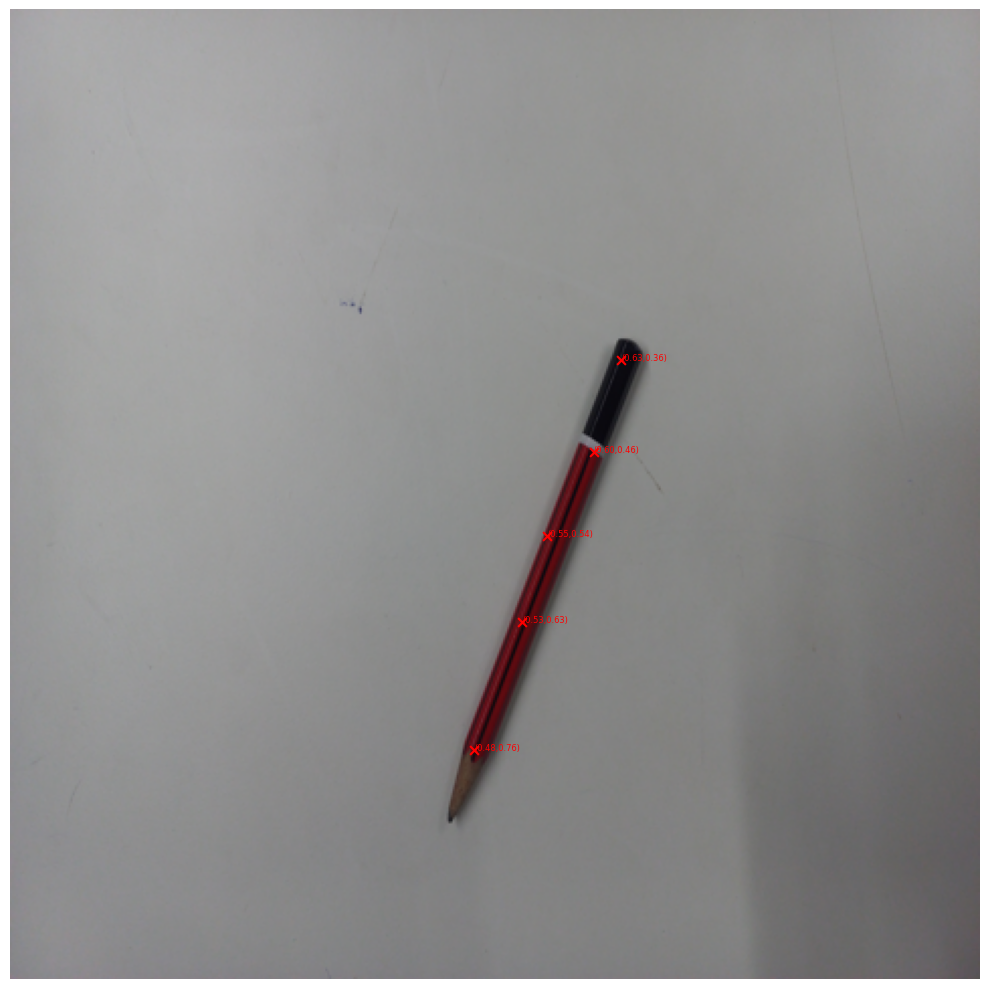

In [ ]:
for image, label in dataloader:
    image_np = image[0].numpy()
    label_np = label[0].numpy()
    if image_np.max() <= 1.0:
        # denormalize image
        image_np = (image_np * 255).astype(np.uint8)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.axis('off')
    img_height, img_width = image_np.shape[:2]
    ax.imshow(image_np)

    for row in range(7):
        for col in range(7):
            x, y, obj = label_np[row, col]
            if obj == 1:
                x_coord = x * img_width
                y_coord = y * img_height
                ax.scatter(x_coord, y_coord, color='red', marker='x', s=40)
                ax.text(x_coord, y_coord, f"({x:.2f},{y:.2f})", fontsize=6, color='red')

    fig.savefig(
        "figures/Figure 1.png",
        dpi=600,
        bbox_inches="tight",
        pad_inches=0,
        format="png"
    )
    plt.tight_layout()
    plt.show()

    break

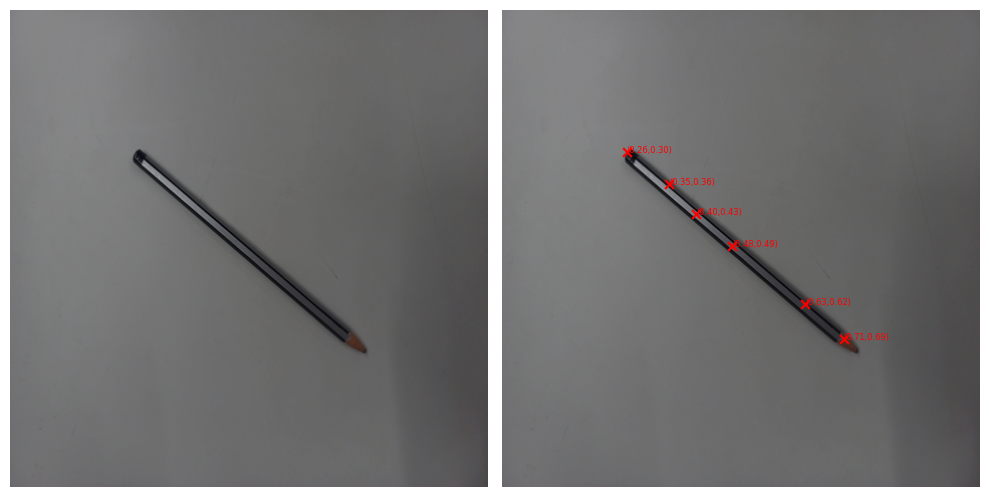

In [ ]:
for image, label in dataloader:
    image_np = image[0].numpy()
    label_np = label[0].numpy()
    if image_np.max() <= 1.0:
        # denormalize image
        image_np = (image_np * 255).astype(np.uint8)

    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    ax0 = axes[0]
    ax0.imshow(image_np)
    ax0.axis('off')
    ax = axes[1]
    ax.axis('off')
    img_height, img_width = image_np.shape[:2]
    ax.imshow(image_np)

    for row in range(7):
        for col in range(7):
            x, y, obj = label_np[row, col]
            if obj == 1:
                x_coord = x * img_width
                y_coord = y * img_height
                ax.scatter(x_coord, y_coord, color='red', marker='x', s=40)
                ax.text(x_coord, y_coord, f"({x:.2f},{y:.2f})", fontsize=6, color='red')

    fig.savefig(
        "figures/Figure 4.png",
        dpi=600,
        bbox_inches="tight",
        pad_inches=0,
        format="png"
    )
    plt.tight_layout()
    plt.show()

    break

20 Images and Labels

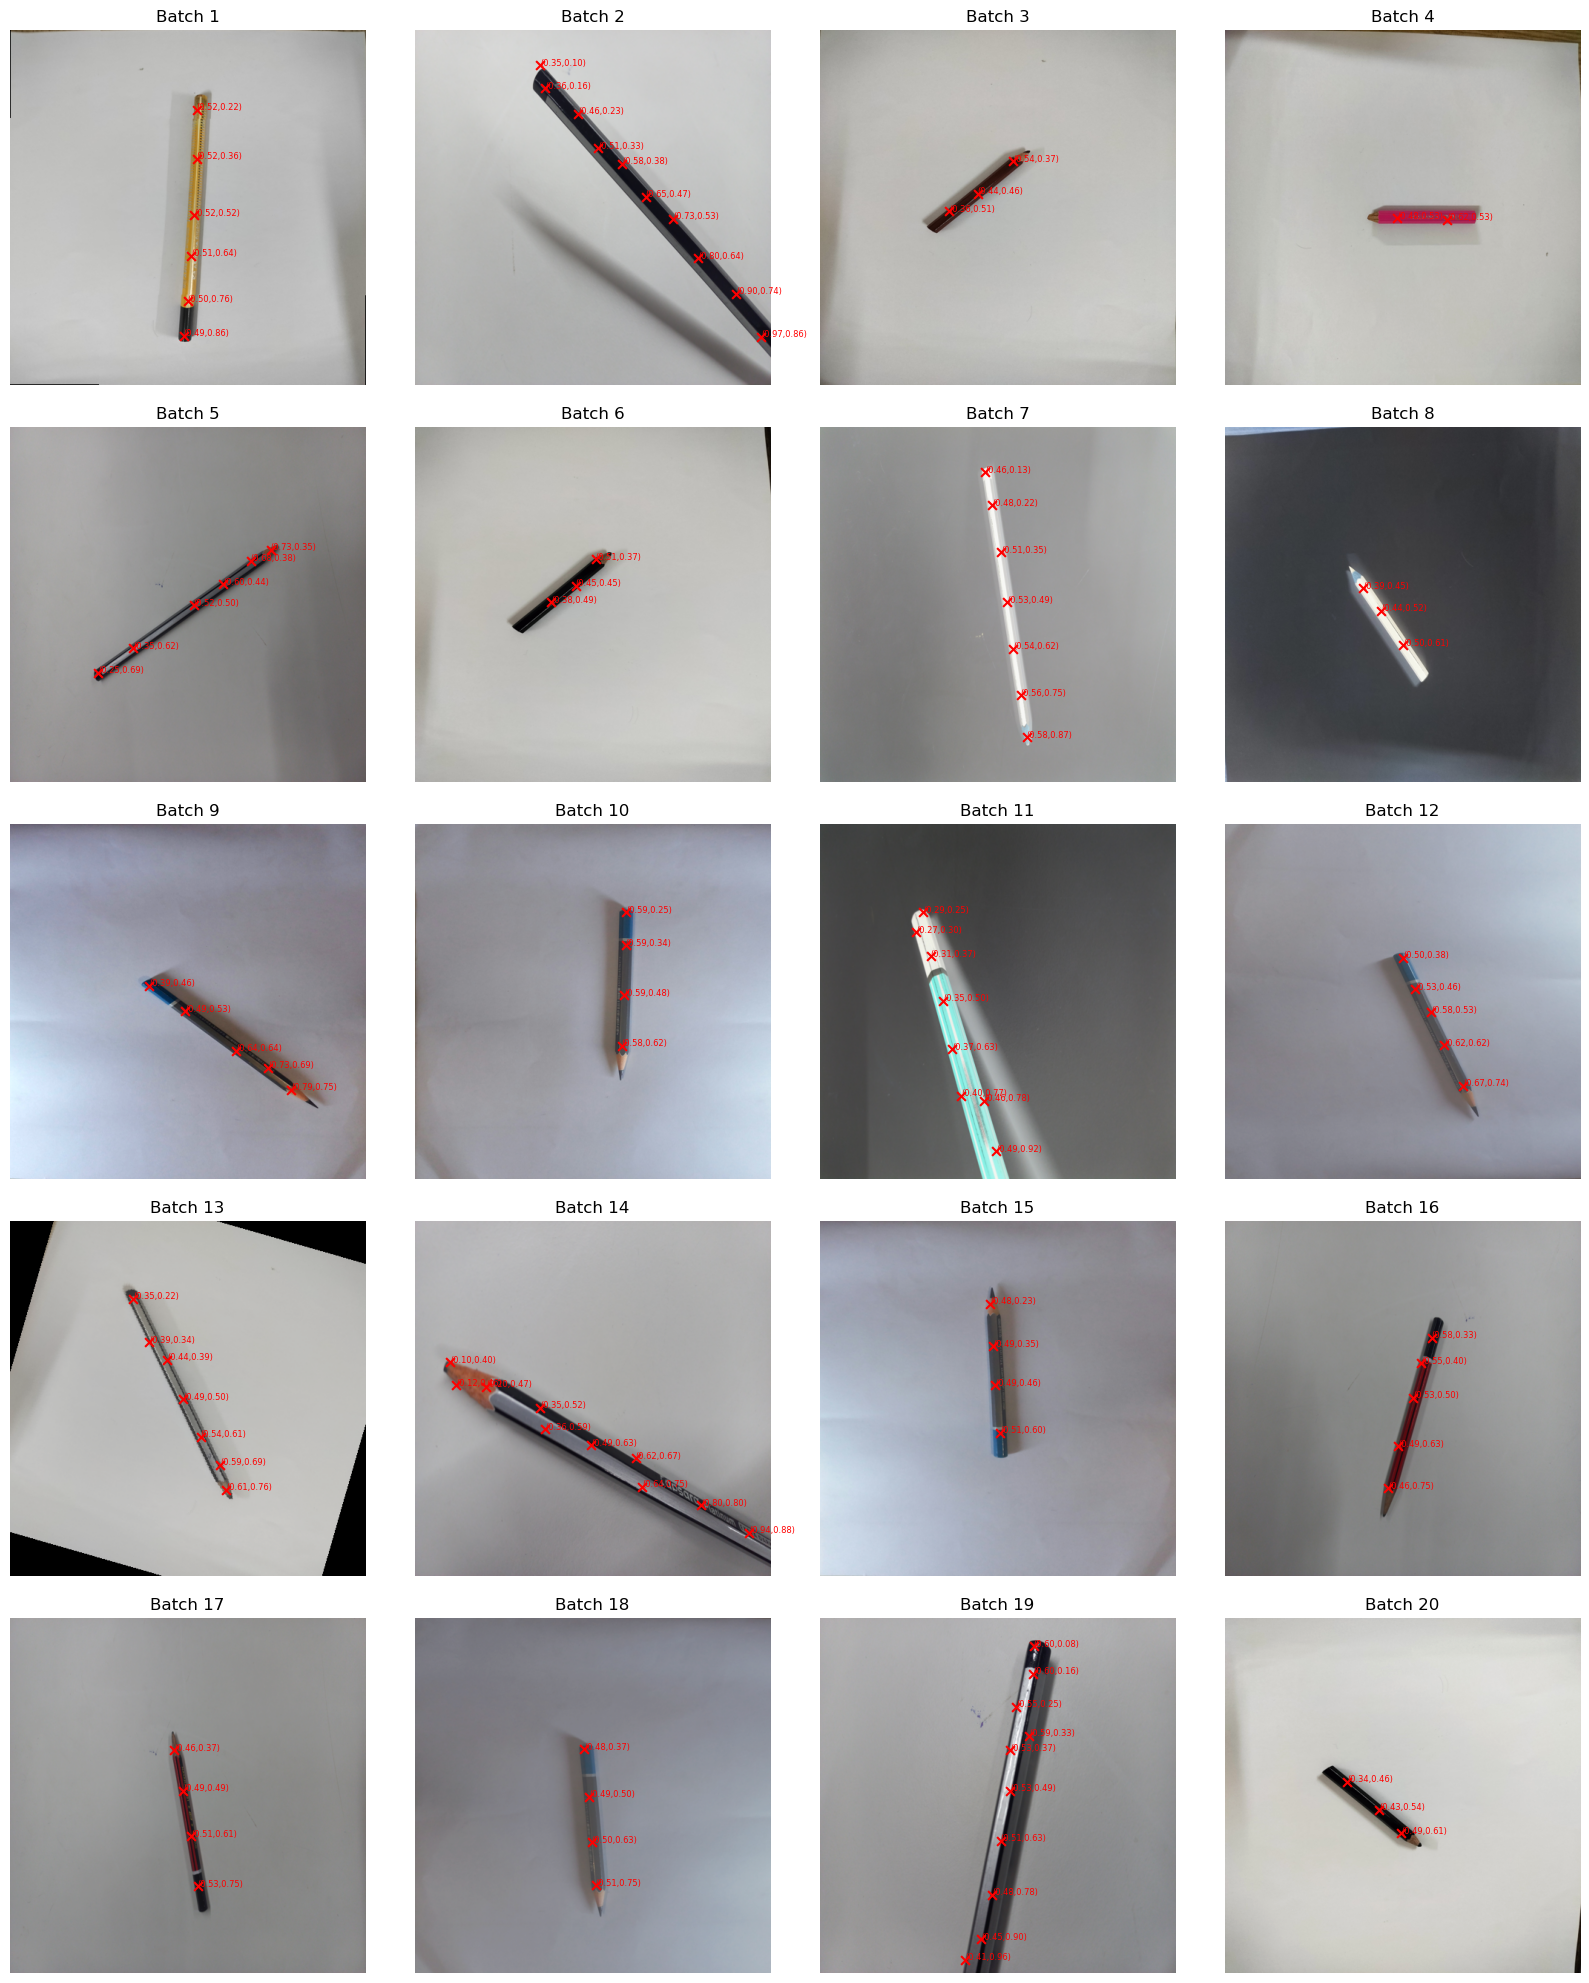

In [11]:
def visualize_dataset(dataloader, num_batches=20, grid_rows=5, grid_cols=4):
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))
    axes = axes.flatten()

    batch_iter = iter(dataloader)

    for batch_idx in range(min(num_batches, len(axes))):
        try:
            image, label = next(batch_iter)
        except StopIteration:
            break  # in case dataloader has fewer than num_batches

        image_np = image[0].numpy()  # (1, 480, 480, 3) -> (480, 480, 3)
        label_np = label[0].numpy()  # (1, 7, 7, 3) -> (7, 7, 3)

        # if image is normalized
        if image_np.max() <= 1.0:
            # denormalize image
            image_np = (image_np * 255).astype(np.uint8)

        img_height, img_width = image_np.shape[:2]
        ax = axes[batch_idx]
        ax.axis('off')

        if image_np.ndim == 2:
            ax.imshow(image_np, cmap='gray')
        else:
            ax.imshow(image_np)

        for row in range(7):
            for col in range(7):
                x, y, obj = label_np[row, col]
                if obj == 1:
                    x_coord = x * img_width
                    y_coord = y * img_height
                    ax.scatter(x_coord, y_coord, color='red', marker='x', s=40)
                    ax.text(x_coord, y_coord, f"({x:.2f},{y:.2f})", fontsize=6, color='red')

        ax.set_title(f"Batch {batch_idx + 1}")

    # turn off unused axes
    for i in range(batch_idx + 1, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_dataset(dataloader)

# Training

In [11]:
device = 'cuda'

In [28]:
# model, optimizer, and custom loss
model = ProtoModel()
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-5)
criterion = locals_loss()

# training parameters
num_epochs = 100
loss_ot = [] # loss overtime

In [13]:
for epoch in range(num_epochs):
    # training on training dataset
    model.train()
    total_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for inputs, targets in pbar:
        inputs = inputs.to(device).permute(0, 3, 1, 2)  # [B, H, W, C] -> [B, C, H, W]
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}: Avg Training Loss = {avg_loss}")
    loss_ot.append(avg_loss)

    # evaluating on validation dataset
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs = val_inputs.to(device).permute(0, 3, 1, 2)
            val_targets = val_targets.to(device)

            val_outputs = model(val_inputs)
            loss= criterion(val_outputs, val_targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}: Avg Validation Loss = {avg_val_loss}")

Epoch 1/100: 100%|██████████| 449/449 [00:13<00:00, 33.11it/s]


Epoch 1: Avg Training Loss = 0.5941463982093175
Epoch 1: Avg Validation Loss = 0.24713038595823142


Epoch 2/100: 100%|██████████| 449/449 [00:13<00:00, 33.84it/s]


Epoch 2: Avg Training Loss = 0.24264765368206198
Epoch 2: Avg Validation Loss = 0.20015421567054895


Epoch 3/100: 100%|██████████| 449/449 [00:13<00:00, 33.89it/s]


Epoch 3: Avg Training Loss = 0.20493694758229372
Epoch 3: Avg Validation Loss = 0.19673815484230334


Epoch 4/100: 100%|██████████| 449/449 [00:13<00:00, 33.93it/s]


Epoch 4: Avg Training Loss = 0.2024610742246255
Epoch 4: Avg Validation Loss = 0.17156122195032927


Epoch 5/100: 100%|██████████| 449/449 [00:13<00:00, 33.84it/s]


Epoch 5: Avg Training Loss = 0.17703799150037872
Epoch 5: Avg Validation Loss = 0.1606215089559555


Epoch 6/100: 100%|██████████| 449/449 [00:13<00:00, 33.87it/s]


Epoch 6: Avg Training Loss = 0.1867932589986011
Epoch 6: Avg Validation Loss = 0.16968941316008568


Epoch 7/100: 100%|██████████| 449/449 [00:13<00:00, 33.85it/s]


Epoch 7: Avg Training Loss = 0.19992366313668827
Epoch 7: Avg Validation Loss = 0.13810004709431759


Epoch 8/100: 100%|██████████| 449/449 [00:13<00:00, 33.88it/s]


Epoch 8: Avg Training Loss = 0.14989493667813877
Epoch 8: Avg Validation Loss = 0.1684091750245828


Epoch 9/100: 100%|██████████| 449/449 [00:13<00:00, 33.90it/s]


Epoch 9: Avg Training Loss = 0.1638030507549942
Epoch 9: Avg Validation Loss = 0.13881280960944983


Epoch 10/100: 100%|██████████| 449/449 [00:13<00:00, 33.90it/s]


Epoch 10: Avg Training Loss = 0.11925396108315357
Epoch 10: Avg Validation Loss = 0.10344206556104697


Epoch 11/100: 100%|██████████| 449/449 [00:13<00:00, 33.90it/s]


Epoch 11: Avg Training Loss = 0.10790148028120697
Epoch 11: Avg Validation Loss = 0.1402000101426473


Epoch 12/100: 100%|██████████| 449/449 [00:13<00:00, 33.90it/s]


Epoch 12: Avg Training Loss = 0.09399912537870003
Epoch 12: Avg Validation Loss = 0.09717868870267501


Epoch 13/100: 100%|██████████| 449/449 [00:13<00:00, 33.93it/s]


Epoch 13: Avg Training Loss = 0.08529766356336048
Epoch 13: Avg Validation Loss = 0.3685602663228145


Epoch 14/100: 100%|██████████| 449/449 [00:13<00:00, 33.91it/s]


Epoch 14: Avg Training Loss = 0.08575901455496893
Epoch 14: Avg Validation Loss = 0.08725417641779551


Epoch 15/100: 100%|██████████| 449/449 [00:13<00:00, 33.89it/s]


Epoch 15: Avg Training Loss = 0.0634897314758768
Epoch 15: Avg Validation Loss = 0.16122034263725465


Epoch 16/100: 100%|██████████| 449/449 [00:13<00:00, 33.71it/s]


Epoch 16: Avg Training Loss = 0.06972367469976368
Epoch 16: Avg Validation Loss = 0.05961158602999953


Epoch 17/100: 100%|██████████| 449/449 [00:13<00:00, 33.87it/s]


Epoch 17: Avg Training Loss = 0.0511110593898757
Epoch 17: Avg Validation Loss = 0.060476487968117


Epoch 18/100: 100%|██████████| 449/449 [00:13<00:00, 33.86it/s]


Epoch 18: Avg Training Loss = 0.06416897922297961
Epoch 18: Avg Validation Loss = 0.06698203287445582


Epoch 19/100: 100%|██████████| 449/449 [00:13<00:00, 33.88it/s]


Epoch 19: Avg Training Loss = 0.05084022921707091
Epoch 19: Avg Validation Loss = 0.09023650818002912


Epoch 20/100: 100%|██████████| 449/449 [00:13<00:00, 33.89it/s]


Epoch 20: Avg Training Loss = 0.05699308048560386
Epoch 20: Avg Validation Loss = 0.05413370081581748


Epoch 21/100: 100%|██████████| 449/449 [00:13<00:00, 33.87it/s]


Epoch 21: Avg Training Loss = 0.053719318424142015
Epoch 21: Avg Validation Loss = 0.054602854706060425


Epoch 22/100: 100%|██████████| 449/449 [00:13<00:00, 33.87it/s]


Epoch 22: Avg Training Loss = 0.04891975748379671
Epoch 22: Avg Validation Loss = 0.1344446141201143


Epoch 23/100: 100%|██████████| 449/449 [00:13<00:00, 33.87it/s]


Epoch 23: Avg Training Loss = 0.041966265098571376
Epoch 23: Avg Validation Loss = 0.05984154429573279


Epoch 24/100: 100%|██████████| 449/449 [00:13<00:00, 33.87it/s]


Epoch 24: Avg Training Loss = 0.04289122571533998
Epoch 24: Avg Validation Loss = 0.06019773749777904


Epoch 25/100: 100%|██████████| 449/449 [00:13<00:00, 33.91it/s]


Epoch 25: Avg Training Loss = 0.03437560386872769
Epoch 25: Avg Validation Loss = 0.04462512679254779


Epoch 26/100: 100%|██████████| 449/449 [00:13<00:00, 33.86it/s]


Epoch 26: Avg Training Loss = 0.04366948984496976
Epoch 26: Avg Validation Loss = 0.10871696687088563


Epoch 27/100: 100%|██████████| 449/449 [00:13<00:00, 33.87it/s]


Epoch 27: Avg Training Loss = 0.049336866950636986
Epoch 27: Avg Validation Loss = 0.04460324615669938


Epoch 28/100: 100%|██████████| 449/449 [00:13<00:00, 33.87it/s]


Epoch 28: Avg Training Loss = 0.03619000715263736
Epoch 28: Avg Validation Loss = 0.09037072551794924


Epoch 29/100: 100%|██████████| 449/449 [00:13<00:00, 33.89it/s]


Epoch 29: Avg Training Loss = 0.03663164901470388
Epoch 29: Avg Validation Loss = 0.04466760860612759


Epoch 30/100: 100%|██████████| 449/449 [00:13<00:00, 33.89it/s]


Epoch 30: Avg Training Loss = 0.03175361079261337
Epoch 30: Avg Validation Loss = 0.04250552935095934


Epoch 31/100: 100%|██████████| 449/449 [00:13<00:00, 33.87it/s]


Epoch 31: Avg Training Loss = 0.03259253536427771
Epoch 31: Avg Validation Loss = 0.04167627014864523


Epoch 32/100: 100%|██████████| 449/449 [00:13<00:00, 33.89it/s]


Epoch 32: Avg Training Loss = 0.029501735707765698
Epoch 32: Avg Validation Loss = 0.0641149953365899


Epoch 33/100: 100%|██████████| 449/449 [00:13<00:00, 33.92it/s]


Epoch 33: Avg Training Loss = 0.029473535259169233
Epoch 33: Avg Validation Loss = 0.04948614870842833


Epoch 34/100: 100%|██████████| 449/449 [00:13<00:00, 33.88it/s]


Epoch 34: Avg Training Loss = 0.03038200531009676
Epoch 34: Avg Validation Loss = 0.045688742449363835


Epoch 35/100: 100%|██████████| 449/449 [00:13<00:00, 33.86it/s]


Epoch 35: Avg Training Loss = 0.029195646614350694
Epoch 35: Avg Validation Loss = 0.041099409465319835


Epoch 36/100: 100%|██████████| 449/449 [00:13<00:00, 33.88it/s]


Epoch 36: Avg Training Loss = 0.02910686946600543
Epoch 36: Avg Validation Loss = 0.05957982789438505


Epoch 37/100: 100%|██████████| 449/449 [00:13<00:00, 33.91it/s]


Epoch 37: Avg Training Loss = 0.029719284595610504
Epoch 37: Avg Validation Loss = 0.03984598836933191


Epoch 38/100: 100%|██████████| 449/449 [00:13<00:00, 33.89it/s]


Epoch 38: Avg Training Loss = 0.024307375333016794
Epoch 38: Avg Validation Loss = 0.03784034204167815


Epoch 39/100: 100%|██████████| 449/449 [00:13<00:00, 33.89it/s]


Epoch 39: Avg Training Loss = 0.02682745081573758
Epoch 39: Avg Validation Loss = 0.049732272423660524


Epoch 40/100: 100%|██████████| 449/449 [00:13<00:00, 33.65it/s]


Epoch 40: Avg Training Loss = 0.026644771460252906
Epoch 40: Avg Validation Loss = 0.03847978742291721


Epoch 41/100: 100%|██████████| 449/449 [00:13<00:00, 33.77it/s]


Epoch 41: Avg Training Loss = 0.027581175482253188
Epoch 41: Avg Validation Loss = 0.0488683375207564


Epoch 42/100: 100%|██████████| 449/449 [00:13<00:00, 33.75it/s]


Epoch 42: Avg Training Loss = 0.01921882639267795
Epoch 42: Avg Validation Loss = 0.0374077338940249


Epoch 43/100: 100%|██████████| 449/449 [00:13<00:00, 33.59it/s]


Epoch 43: Avg Training Loss = 0.02238193612425424
Epoch 43: Avg Validation Loss = 0.04132541680995088


Epoch 44/100: 100%|██████████| 449/449 [00:13<00:00, 33.82it/s]


Epoch 44: Avg Training Loss = 0.021018190356075165
Epoch 44: Avg Validation Loss = 0.03745225824129123


Epoch 45/100: 100%|██████████| 449/449 [00:13<00:00, 33.88it/s]


Epoch 45: Avg Training Loss = 0.02375740276645446
Epoch 45: Avg Validation Loss = 0.03702871909794899


Epoch 46/100: 100%|██████████| 449/449 [00:13<00:00, 33.93it/s]


Epoch 46: Avg Training Loss = 0.019368996529452055
Epoch 46: Avg Validation Loss = 0.038298069983004376


Epoch 47/100: 100%|██████████| 449/449 [00:13<00:00, 33.92it/s]


Epoch 47: Avg Training Loss = 0.016143246575617512
Epoch 47: Avg Validation Loss = 0.03592430877212722


Epoch 48/100: 100%|██████████| 449/449 [00:13<00:00, 33.94it/s]


Epoch 48: Avg Training Loss = 0.02405605178257919
Epoch 48: Avg Validation Loss = 0.034529987149513684


Epoch 49/100: 100%|██████████| 449/449 [00:13<00:00, 33.93it/s]


Epoch 49: Avg Training Loss = 0.016771466257092117
Epoch 49: Avg Validation Loss = 0.03886308977738596


Epoch 50/100: 100%|██████████| 449/449 [00:13<00:00, 33.94it/s]


Epoch 50: Avg Training Loss = 0.021145689574989152
Epoch 50: Avg Validation Loss = 0.03861763543234421


Epoch 51/100: 100%|██████████| 449/449 [00:13<00:00, 33.89it/s]


Epoch 51: Avg Training Loss = 0.018986012398748593
Epoch 51: Avg Validation Loss = 0.038574315052336224


Epoch 52/100: 100%|██████████| 449/449 [00:13<00:00, 33.92it/s]


Epoch 52: Avg Training Loss = 0.016443975319057072
Epoch 52: Avg Validation Loss = 0.056950784754008055


Epoch 53/100: 100%|██████████| 449/449 [00:13<00:00, 33.93it/s]


Epoch 53: Avg Training Loss = 0.01621930649450136
Epoch 53: Avg Validation Loss = 0.037833493328295074


Epoch 54/100: 100%|██████████| 449/449 [00:13<00:00, 33.92it/s]


Epoch 54: Avg Training Loss = 0.022618802127434577
Epoch 54: Avg Validation Loss = 0.04410855253585256


Epoch 55/100: 100%|██████████| 449/449 [00:13<00:00, 33.92it/s]


Epoch 55: Avg Training Loss = 0.018769644418594432
Epoch 55: Avg Validation Loss = 0.0389546172406811


Epoch 56/100: 100%|██████████| 449/449 [00:13<00:00, 33.90it/s]


Epoch 56: Avg Training Loss = 0.016218469869179488
Epoch 56: Avg Validation Loss = 0.036999126591791325


Epoch 57/100: 100%|██████████| 449/449 [00:13<00:00, 33.93it/s]


Epoch 57: Avg Training Loss = 0.013109168085997679
Epoch 57: Avg Validation Loss = 0.03711248767705491


Epoch 58/100: 100%|██████████| 449/449 [00:13<00:00, 33.93it/s]


Epoch 58: Avg Training Loss = 0.018574167909992563
Epoch 58: Avg Validation Loss = 0.0369534210409396


Epoch 59/100: 100%|██████████| 449/449 [00:13<00:00, 33.90it/s]


Epoch 59: Avg Training Loss = 0.015290980028166935
Epoch 59: Avg Validation Loss = 0.034915309865027666


Epoch 60/100: 100%|██████████| 449/449 [00:13<00:00, 33.89it/s]


Epoch 60: Avg Training Loss = 0.01368512539452311
Epoch 60: Avg Validation Loss = 0.04284347656469505


Epoch 61/100: 100%|██████████| 449/449 [00:13<00:00, 33.91it/s]


Epoch 61: Avg Training Loss = 0.01660991952192445
Epoch 61: Avg Validation Loss = 0.03435256280219899


Epoch 62/100: 100%|██████████| 449/449 [00:13<00:00, 33.84it/s]


Epoch 62: Avg Training Loss = 0.013757479515544789
Epoch 62: Avg Validation Loss = 0.044363248717183106


Epoch 63/100: 100%|██████████| 449/449 [00:13<00:00, 33.93it/s]


Epoch 63: Avg Training Loss = 0.013065778834948562
Epoch 63: Avg Validation Loss = 0.04267799066236386


Epoch 64/100: 100%|██████████| 449/449 [00:13<00:00, 33.91it/s]


Epoch 64: Avg Training Loss = 0.01479446847315355
Epoch 64: Avg Validation Loss = 0.03665673120233875


Epoch 65/100: 100%|██████████| 449/449 [00:13<00:00, 33.92it/s]


Epoch 65: Avg Training Loss = 0.014622385494352914
Epoch 65: Avg Validation Loss = 0.04242505828061929


Epoch 66/100: 100%|██████████| 449/449 [00:13<00:00, 33.73it/s]


Epoch 66: Avg Training Loss = 0.011896444463849333
Epoch 66: Avg Validation Loss = 0.03957423188078862


Epoch 67/100: 100%|██████████| 449/449 [00:13<00:00, 33.79it/s]


Epoch 67: Avg Training Loss = 0.015355970878527398
Epoch 67: Avg Validation Loss = 0.037974435316685304


Epoch 68/100: 100%|██████████| 449/449 [00:13<00:00, 33.84it/s]


Epoch 68: Avg Training Loss = 0.01580011413561259
Epoch 68: Avg Validation Loss = 0.0373127491464122


Epoch 69/100: 100%|██████████| 449/449 [00:13<00:00, 33.87it/s]


Epoch 69: Avg Training Loss = 0.011551244227414771
Epoch 69: Avg Validation Loss = 0.035144390287594154


Epoch 70/100: 100%|██████████| 449/449 [00:13<00:00, 33.88it/s]


Epoch 70: Avg Training Loss = 0.010823325412181976
Epoch 70: Avg Validation Loss = 0.03867404161092754


Epoch 71/100: 100%|██████████| 449/449 [00:13<00:00, 33.90it/s]


Epoch 71: Avg Training Loss = 0.013069029422456146
Epoch 71: Avg Validation Loss = 0.039743000480274744


Epoch 72/100: 100%|██████████| 449/449 [00:13<00:00, 33.90it/s]


Epoch 72: Avg Training Loss = 0.016577420480868764
Epoch 72: Avg Validation Loss = 0.03728159026314433


Epoch 73/100: 100%|██████████| 449/449 [00:13<00:00, 33.88it/s]


Epoch 73: Avg Training Loss = 0.012214553921497976
Epoch 73: Avg Validation Loss = 0.03390515149714282


Epoch 74/100: 100%|██████████| 449/449 [00:13<00:00, 33.90it/s]


Epoch 74: Avg Training Loss = 0.010214361210222997
Epoch 74: Avg Validation Loss = 0.04018627254901311


Epoch 75/100: 100%|██████████| 449/449 [00:13<00:00, 33.89it/s]


Epoch 75: Avg Training Loss = 0.012098905431285068
Epoch 75: Avg Validation Loss = 0.04394784713020691


Epoch 76/100: 100%|██████████| 449/449 [00:13<00:00, 33.87it/s]


Epoch 76: Avg Training Loss = 0.012195066812827785
Epoch 76: Avg Validation Loss = 0.03738711443013297


Epoch 77/100: 100%|██████████| 449/449 [00:13<00:00, 33.94it/s]


Epoch 77: Avg Training Loss = 0.012559694734263029
Epoch 77: Avg Validation Loss = 0.03592437007822669


Epoch 78/100: 100%|██████████| 449/449 [00:13<00:00, 33.88it/s]


Epoch 78: Avg Training Loss = 0.011191624697953264
Epoch 78: Avg Validation Loss = 0.03579494351736055


Epoch 79/100: 100%|██████████| 449/449 [00:13<00:00, 33.87it/s]


Epoch 79: Avg Training Loss = 0.010374528373008748
Epoch 79: Avg Validation Loss = 0.03569164499640465


Epoch 80/100: 100%|██████████| 449/449 [00:13<00:00, 33.90it/s]


Epoch 80: Avg Training Loss = 0.013342849966781608
Epoch 80: Avg Validation Loss = 0.039109068260026664


Epoch 81/100: 100%|██████████| 449/449 [00:13<00:00, 33.90it/s]


Epoch 81: Avg Training Loss = 0.011862793800945836
Epoch 81: Avg Validation Loss = 0.03756129305558996


Epoch 82/100: 100%|██████████| 449/449 [00:13<00:00, 33.88it/s]


Epoch 82: Avg Training Loss = 0.010741191507547364
Epoch 82: Avg Validation Loss = 0.03969916968176571


Epoch 83/100: 100%|██████████| 449/449 [00:13<00:00, 33.89it/s]


Epoch 83: Avg Training Loss = 0.009641622600222385
Epoch 83: Avg Validation Loss = 0.03893141247905218


Epoch 84/100: 100%|██████████| 449/449 [00:13<00:00, 33.81it/s]


Epoch 84: Avg Training Loss = 0.009542492125494476
Epoch 84: Avg Validation Loss = 0.03857873587940748


Epoch 85/100: 100%|██████████| 449/449 [00:13<00:00, 33.90it/s]


Epoch 85: Avg Training Loss = 0.011784577220553876
Epoch 85: Avg Validation Loss = 0.0448990915543758


Epoch 86/100: 100%|██████████| 449/449 [00:13<00:00, 33.87it/s]


Epoch 86: Avg Training Loss = 0.009402963095852786
Epoch 86: Avg Validation Loss = 0.03935541885976608


Epoch 87/100: 100%|██████████| 449/449 [00:13<00:00, 33.90it/s]


Epoch 87: Avg Training Loss = 0.011544078764794
Epoch 87: Avg Validation Loss = 0.041220539213659674


Epoch 88/100: 100%|██████████| 449/449 [00:13<00:00, 33.90it/s]


Epoch 88: Avg Training Loss = 0.01054768806389784
Epoch 88: Avg Validation Loss = 0.03883990199448398


Epoch 89/100: 100%|██████████| 449/449 [00:13<00:00, 33.94it/s]


Epoch 89: Avg Training Loss = 0.010057740250004991
Epoch 89: Avg Validation Loss = 0.03805092209054587


Epoch 90/100: 100%|██████████| 449/449 [00:13<00:00, 33.90it/s]


Epoch 90: Avg Training Loss = 0.010984084444464847
Epoch 90: Avg Validation Loss = 0.04219708220961575


Epoch 91/100: 100%|██████████| 449/449 [00:13<00:00, 33.90it/s]


Epoch 91: Avg Training Loss = 0.009994326677911797
Epoch 91: Avg Validation Loss = 0.038952399940731436


Epoch 92/100: 100%|██████████| 449/449 [00:13<00:00, 33.91it/s]


Epoch 92: Avg Training Loss = 0.008526556101526011
Epoch 92: Avg Validation Loss = 0.03940479462751402


Epoch 93/100: 100%|██████████| 449/449 [00:13<00:00, 33.91it/s]


Epoch 93: Avg Training Loss = 0.010166302357565918
Epoch 93: Avg Validation Loss = 0.04086786504978171


Epoch 94/100: 100%|██████████| 449/449 [00:13<00:00, 33.90it/s]


Epoch 94: Avg Training Loss = 0.009717100551911943
Epoch 94: Avg Validation Loss = 0.040043987011393674


Epoch 95/100: 100%|██████████| 449/449 [00:13<00:00, 33.89it/s]


Epoch 95: Avg Training Loss = 0.009762626039673199
Epoch 95: Avg Validation Loss = 0.03499925073880989


Epoch 96/100: 100%|██████████| 449/449 [00:13<00:00, 33.92it/s]


Epoch 96: Avg Training Loss = 0.010670138309856997
Epoch 96: Avg Validation Loss = 0.03655793433650755


Epoch 97/100: 100%|██████████| 449/449 [00:13<00:00, 33.92it/s]


Epoch 97: Avg Training Loss = 0.008208339037228467
Epoch 97: Avg Validation Loss = 0.04301739068558583


Epoch 98/100: 100%|██████████| 449/449 [00:13<00:00, 33.94it/s]


Epoch 98: Avg Training Loss = 0.00839350435971998
Epoch 98: Avg Validation Loss = 0.04198905093093904


Epoch 99/100: 100%|██████████| 449/449 [00:13<00:00, 33.85it/s]


Epoch 99: Avg Training Loss = 0.008755885172461083
Epoch 99: Avg Validation Loss = 0.03635276545985387


Epoch 100/100: 100%|██████████| 449/449 [00:13<00:00, 33.88it/s]


Epoch 100: Avg Training Loss = 0.008812300014083495
Epoch 100: Avg Validation Loss = 0.04006233734365266


# Saving and Loading Model

In [14]:
torch.save(model.state_dict(), "model-single.pth") 

In [12]:
model = ProtoModel()
model.to(device)
model.load_state_dict(torch.load("model-single.pth"))
model.eval()

C:\Users\agile\AppData\Local\Temp\ipykernel_13856\58767062.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model-single.pth"))


ProtoModel(
  (feature_extractor): FeatureExtractor(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): ReLU(inplace=True)
      (2): LayerNorm((64, 240, 240), eps=1e-05, elementwise_affine=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): LayerNorm((192, 60, 60), eps=1e-05, elementwise_affine=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): LayerNorm((256, 30, 30), eps=1e-05, elementwise_affine=True)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): LayerNorm((512, 30, 30), eps=1e-05, elementwise_affine=True)
      (14): MaxPool2d(ker

# Graphing Loss

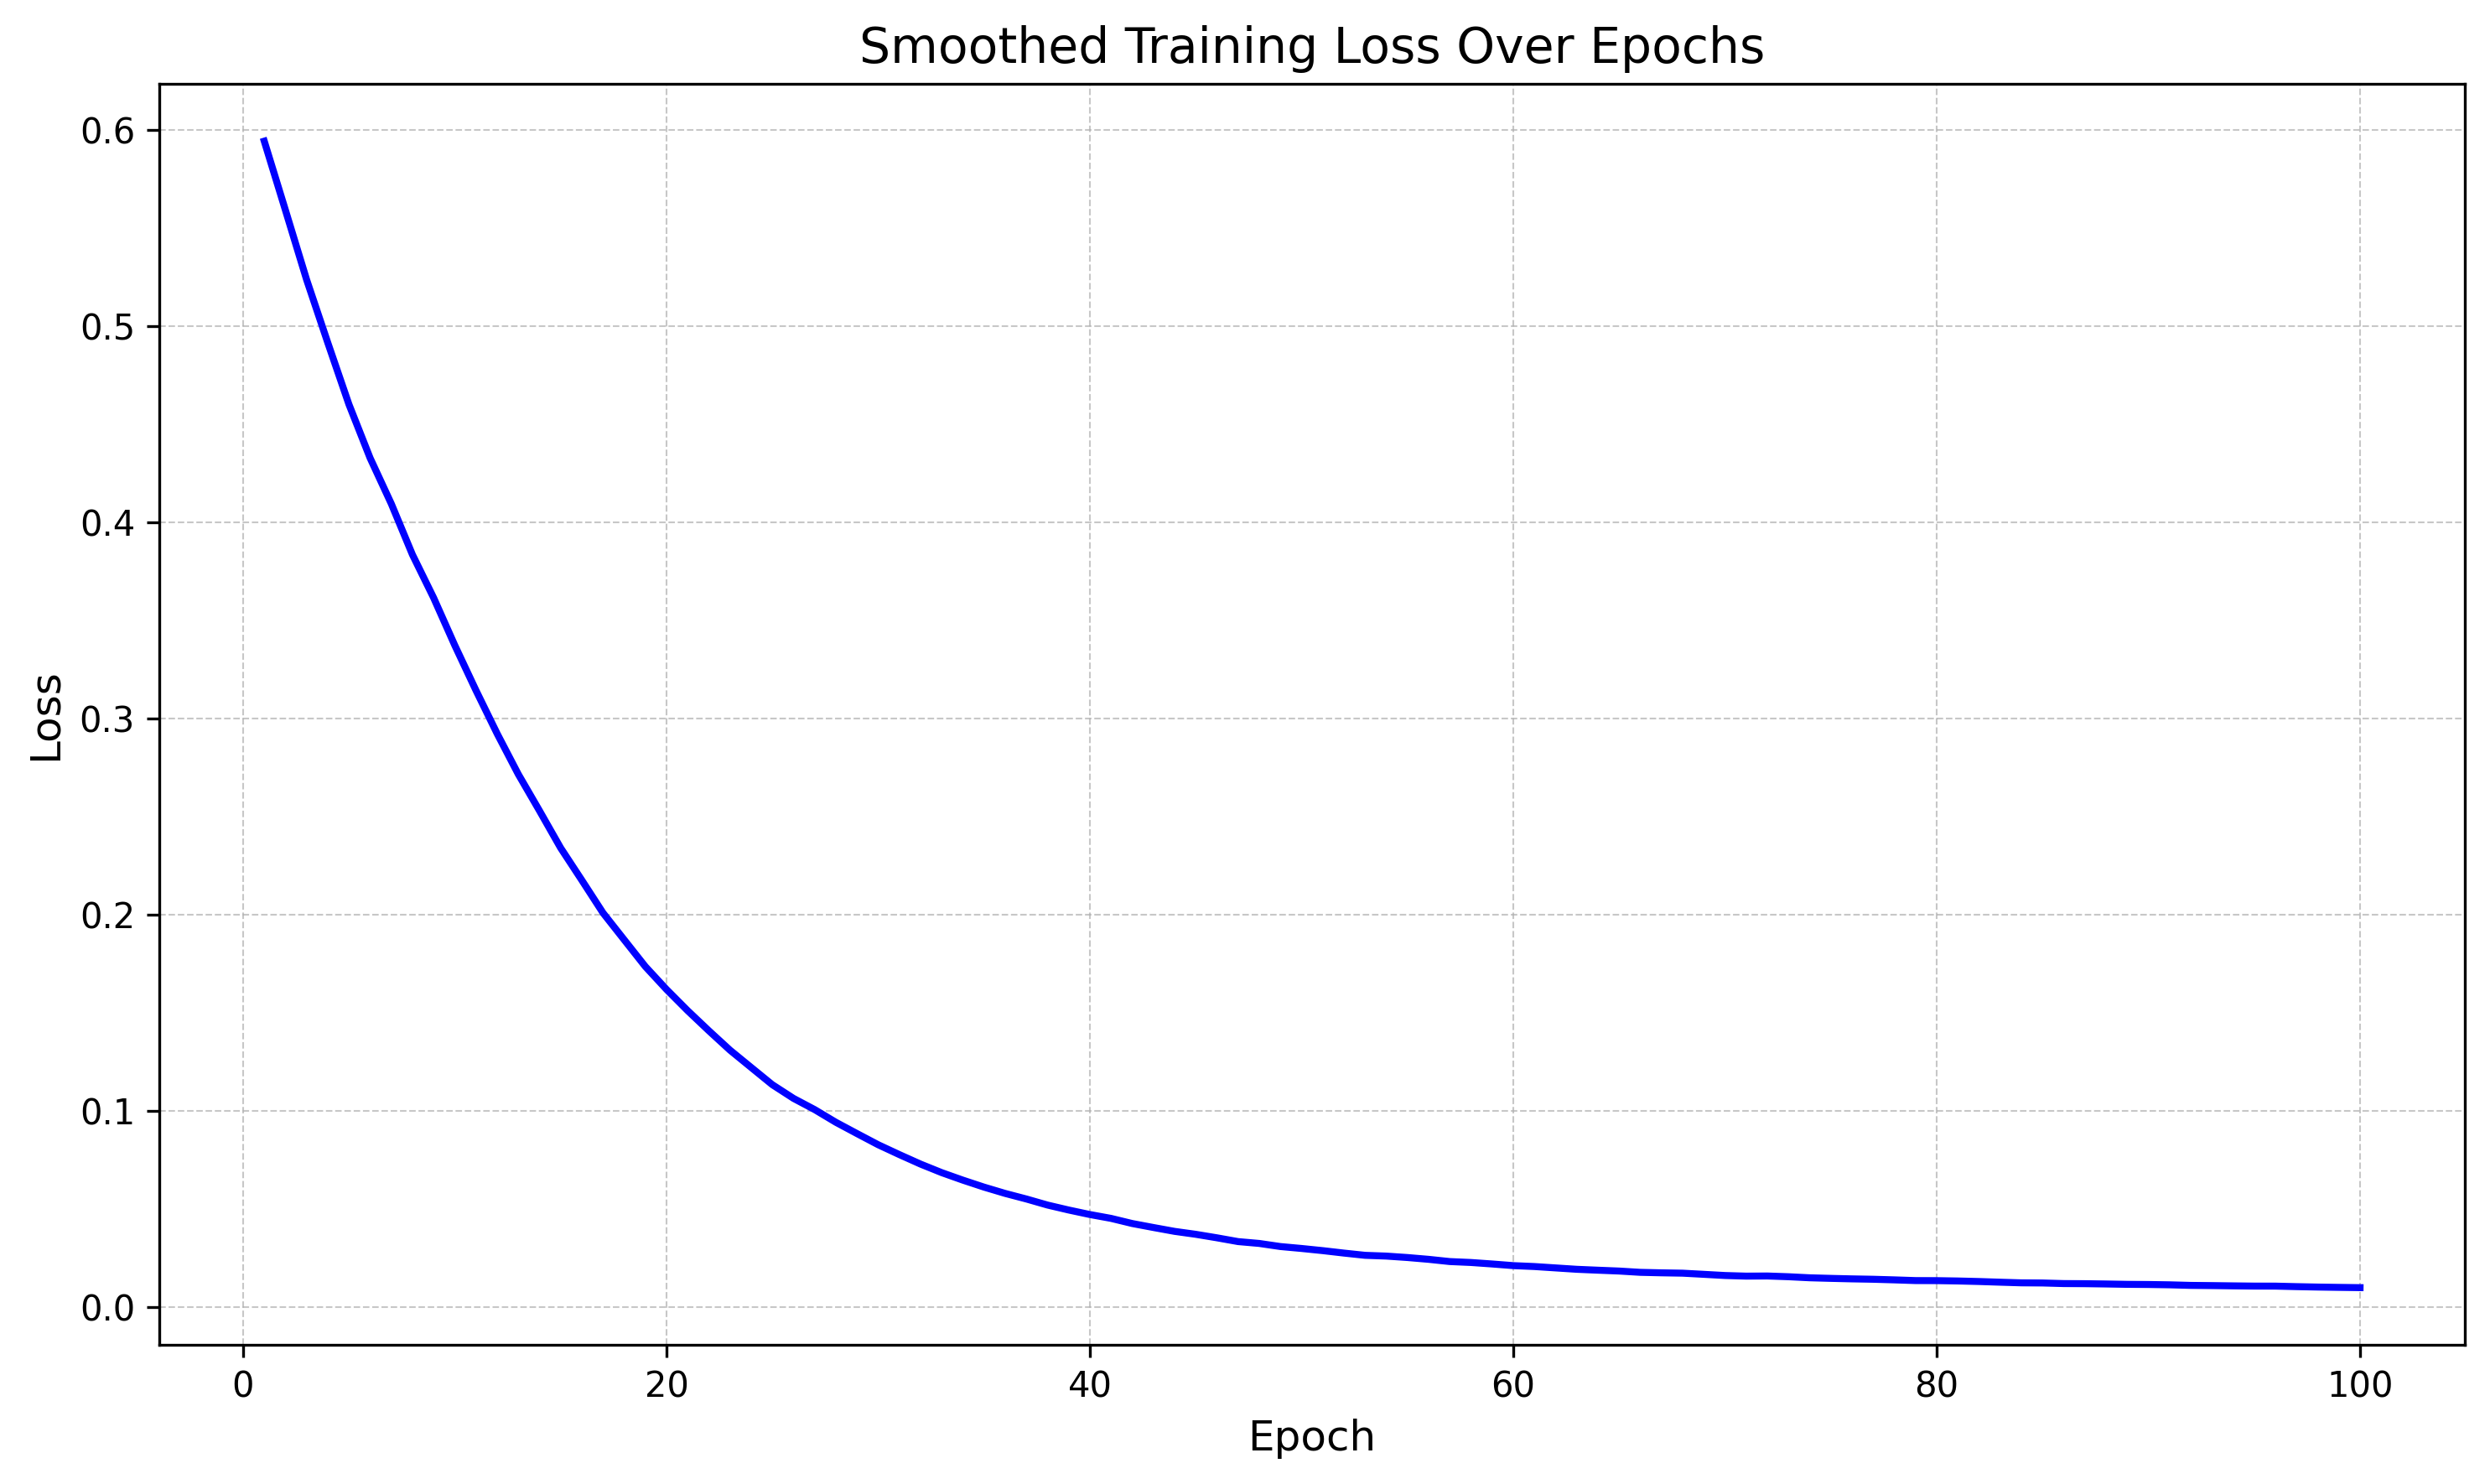

In [ ]:
def smooth_curve(points, factor=0.9):
    # applies exponential smoothing to a curve
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

# extract raw loss and val_loss from history
loss = loss_ot
val_loss = None

# smooth the losses
smooth_loss = smooth_curve(loss)
smooth_val_loss = smooth_curve(val_loss) if val_loss is not None else None

# plot the smoothed losses
epochs = range(1, len(smooth_loss) + 1)
plt.figure(figsize=(10, 6), dpi=300)  # High-res
plt.plot(epochs, smooth_loss, color='blue', linewidth=2)
plt.title(r'Smoothed Training Loss Over Epochs', fontsize=14)
plt.xlabel(r'Epoch', fontsize=12)
plt.ylabel(r'Loss', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("figures/smoothed_training_loss.png", dpi=300)
plt.show()

# Testing

Single Image and Label

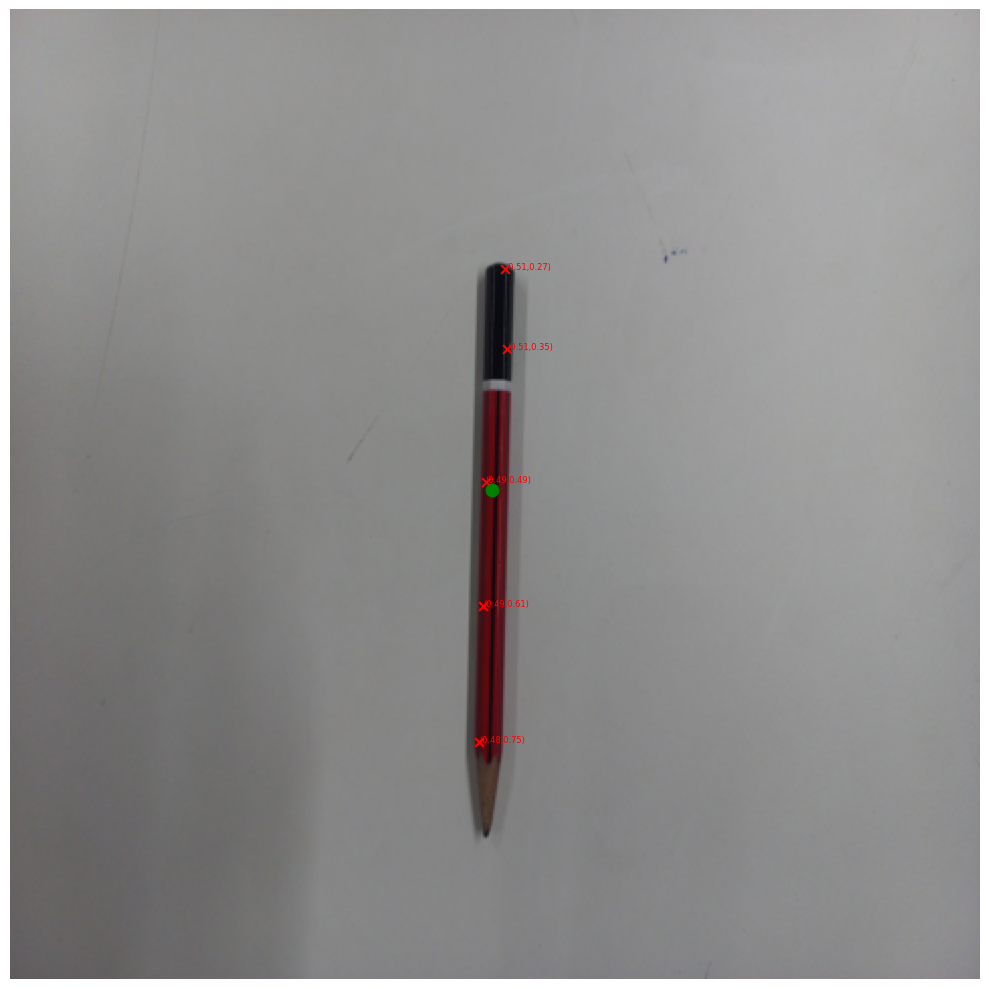

In [ ]:
model.eval()

for images, label in dataloader:
    # move image to device and forward pass
    image_tensor = images[0].unsqueeze(0).to(device) # [1, H, W, C]
    image_tensor = image_tensor.permute(0, 3, 1, 2) # [1, C, H, W]
    prediction = model(image_tensor)[0].detach().cpu().numpy() # shape: [7, 7, 3]

    image_numpy = images[0].cpu().numpy() # [H, W, C]
    if image_numpy.max() <= 1.0:
        image_numpy = (image_numpy * 255).astype(np.uint8)

    img_height, img_width = image_numpy.shape[:2]

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.axis('off')
    img_height, img_width = image_np.shape[:2]
    ax.imshow(image_numpy)

    x_sum = 0
    y_sum = 0
    count = 0
    for row in range(7):
        for col in range(7):
            x, y, obj = prediction[row, col]
            if obj > 0.5:
                count += 1
                x_coord = x * img_width
                x_sum += x_coord
                y_coord = y * img_height
                y_sum += y_coord
                ax.scatter(x_coord, y_coord, color='red', marker='x', s=40)
                ax.text(x_coord, y_coord, f"({x:.2f},{y:.2f})", fontsize=6, color='red')

    ax.scatter(np.array([x_sum / count]), np.array([y_sum / count]), color='green', marker='o', s=80)

    fig.savefig(
        "figures/Figure 3.png",
        dpi=600,
        bbox_inches="tight",
        pad_inches=0,
        format="png"
    )
    plt.tight_layout()
    plt.show()

    break

20 Images and Labels

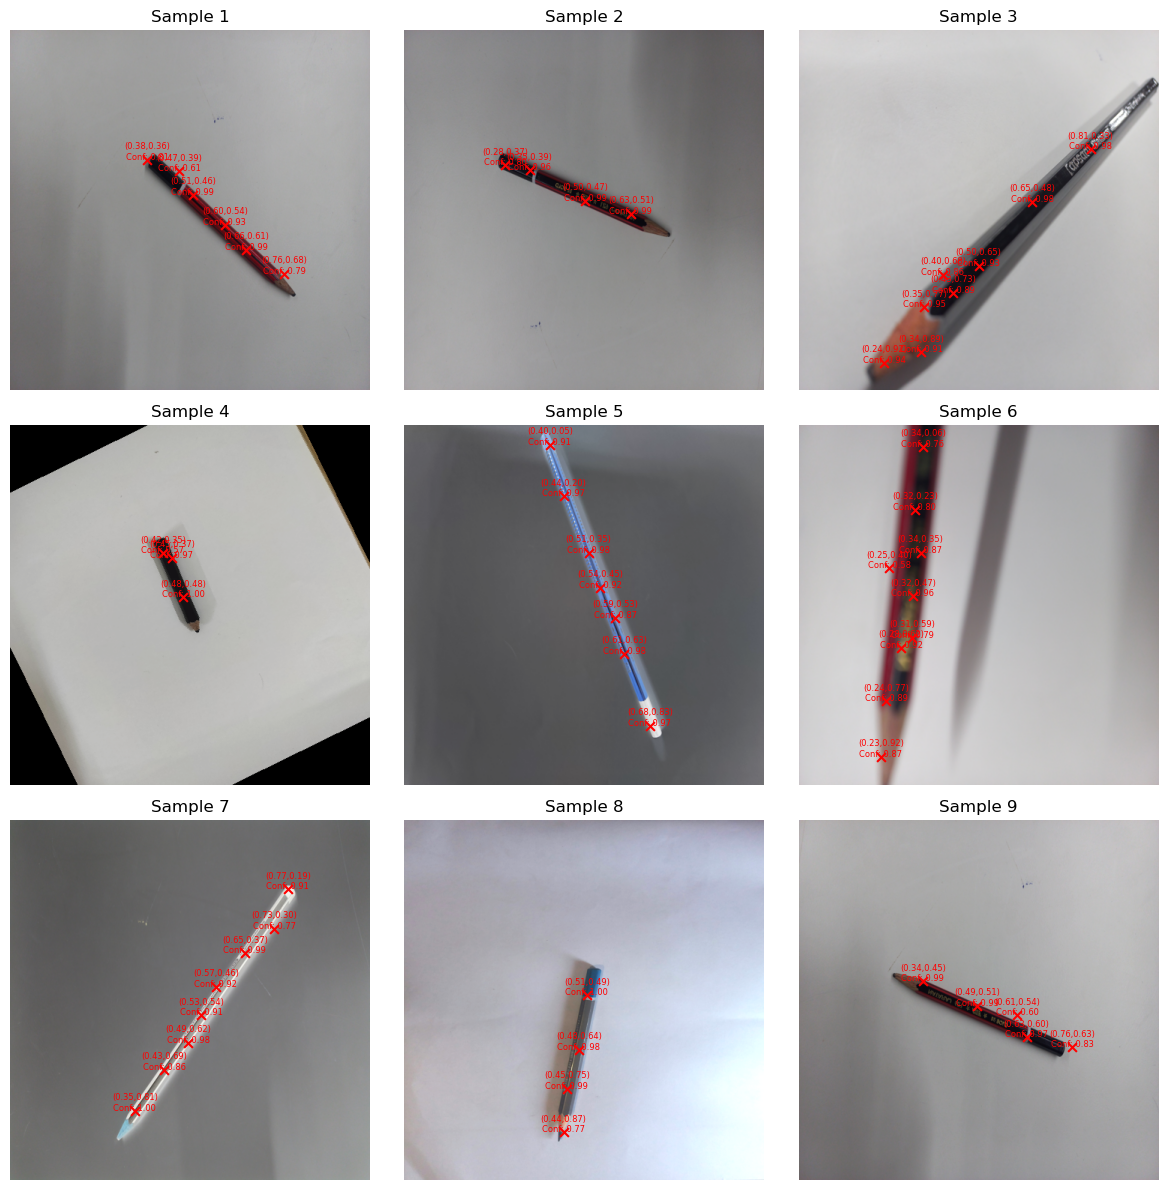

In [ ]:
def visualize_predictions(model, dataloader, num_batches=20, grid_rows=4, grid_cols=5):
    model.eval()

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))
    axes = axes.flatten()

    with torch.no_grad():
        batch_idx = 0
        for images, _ in dataloader:
            if batch_idx >= num_batches:
                break

            # move image to device and forward pass
            image_tensor = images[0].unsqueeze(0).to(device) # [1, H, W, C]
            image_tensor = image_tensor.permute(0, 3, 1, 2) # [1, C, H, W]
            prediction = model(image_tensor)[0].detach().cpu().numpy() # shape: [7, 7, 3]

            image_numpy = images[0].cpu().numpy() # [H, W, C]
            if image_numpy.max() <= 1.0:
                image_numpy = (image_numpy * 255).astype(np.uint8)

            img_height, img_width = image_numpy.shape[:2]

            # plotting
            ax = axes[batch_idx]
            ax.imshow(image_numpy)
            ax.set_title(f"Sample {batch_idx + 1}")
            ax.axis('off')

            x_coords, y_coords = [], []

            for row in range(7):
                for col in range(7):
                    x, y, obj = prediction[row, col]
                    if obj > 0.5:
                        x_coord = x * img_width
                        y_coord = y * img_height
                        ax.scatter(x_coord, y_coord, color='red', marker='x', s=40)
                        ax.text(
                            x_coord, y_coord,
                            f"({x:.2f},{y:.2f})\nConf: {obj:.2f}",
                            fontsize=6, color='red', ha='center'
                        )
                        x_coords.append(x_coord)
                        y_coords.append(y_coord)

            batch_idx += 1

    # hide unused subplots
    for i in range(batch_idx, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(
        "figures/test_results.png",
        dpi=600,
        bbox_inches="tight",
        pad_inches=0,
        format="png"
    )
    plt.show()

visualize_predictions(model, test_loader, num_batches=9, grid_rows=3, grid_cols=3)

# Visualizing What the Model Sees

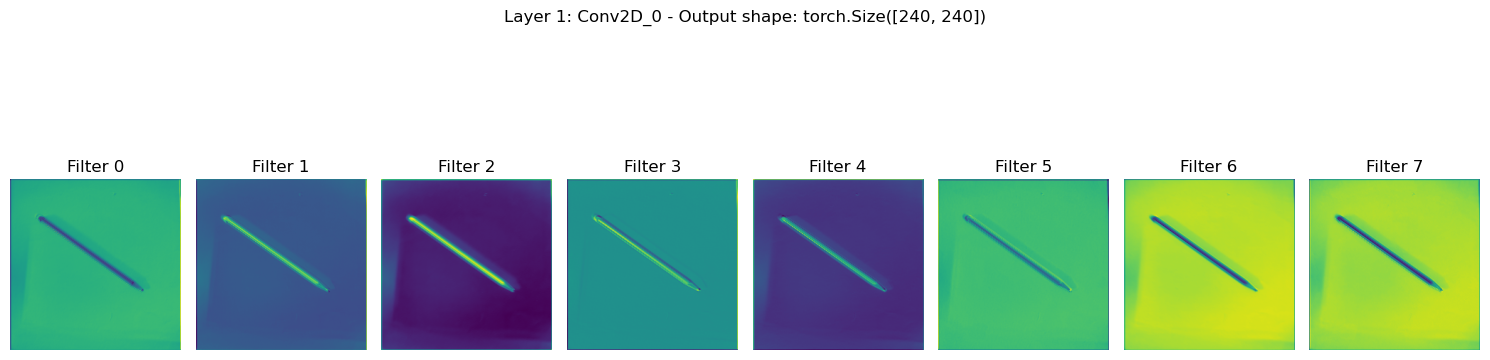

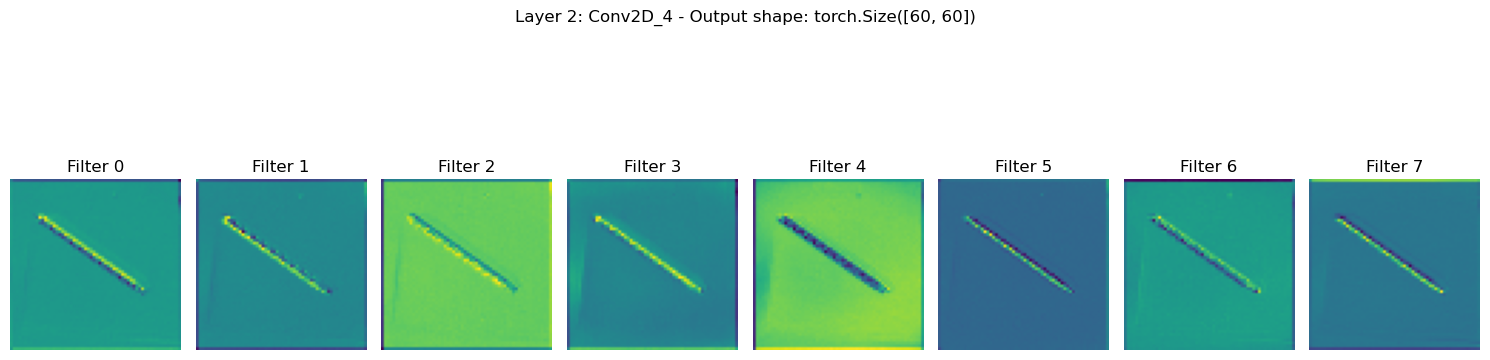

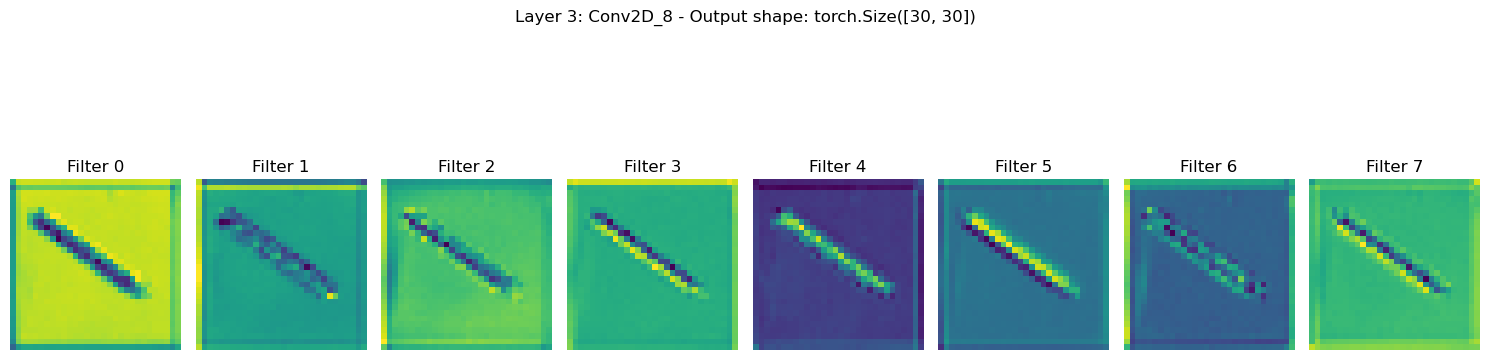

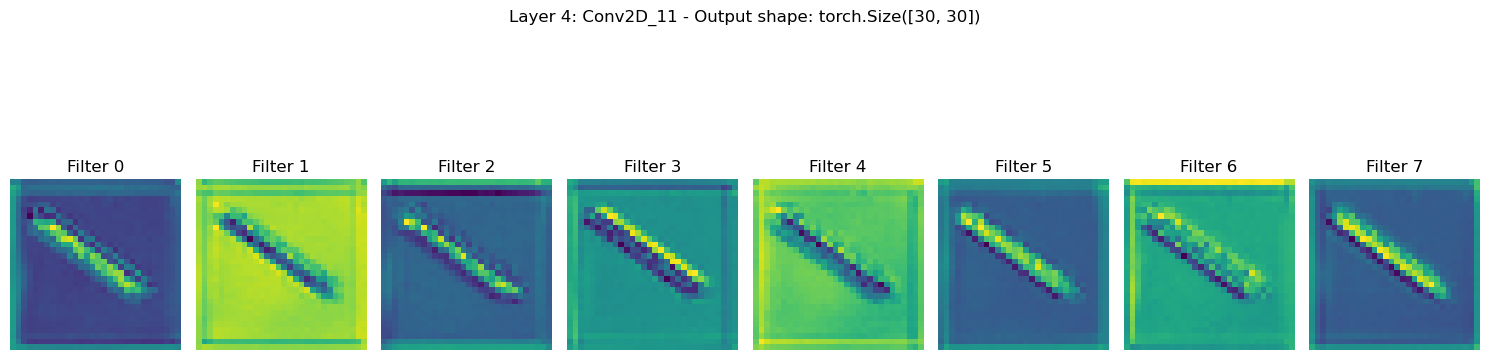

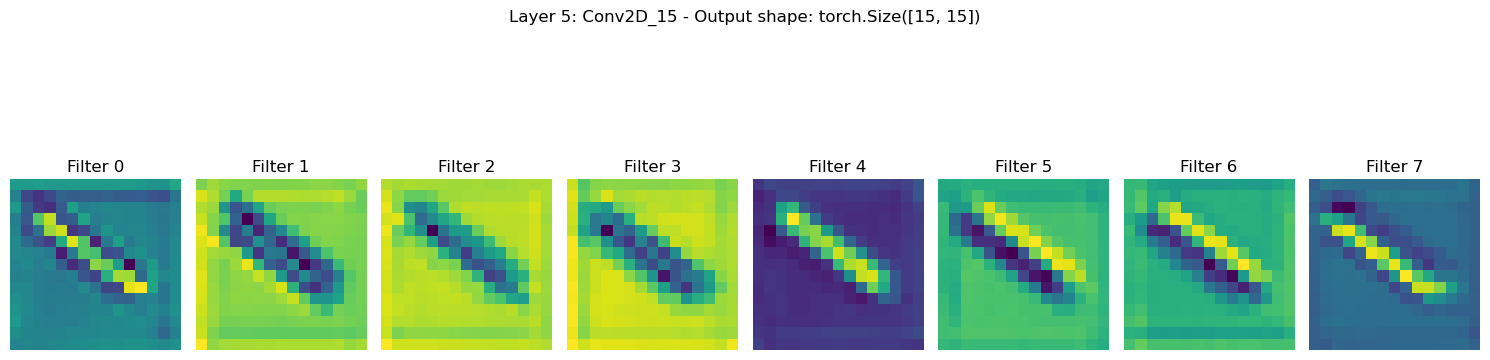

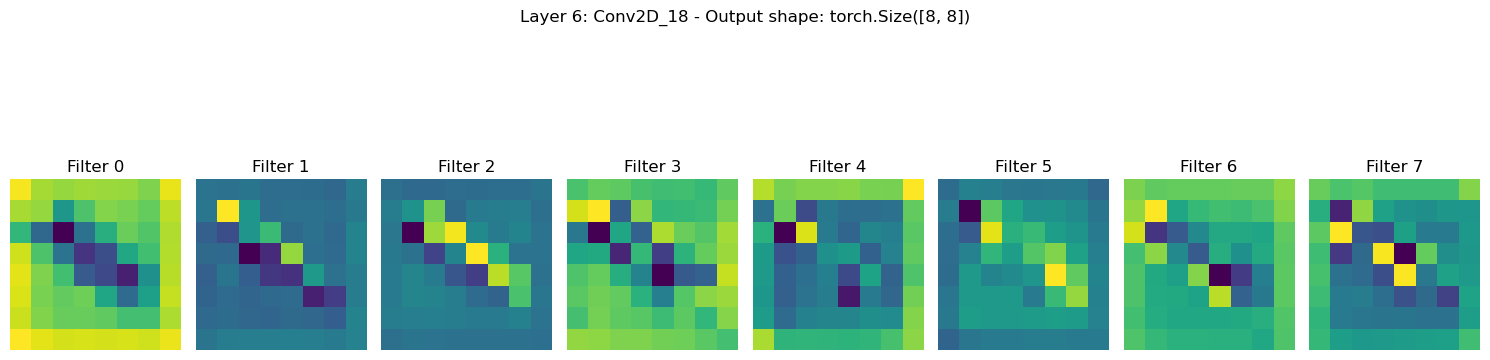

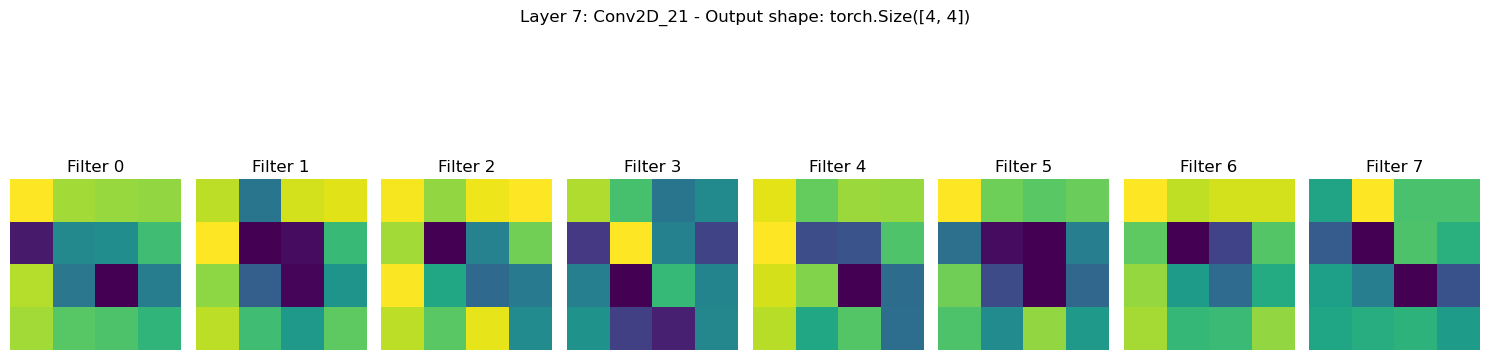

In [ ]:
# list of indeces of Conv2D layers in model
conv_indices = [0, 4, 8, 11, 15, 18, 21]

# get a single batch from the dataloader
for batch_idx, (images, labels) in enumerate(dataloader):
    if batch_idx == 0:  # take first batch
        # take only the first image in the batch
        image_tensor = images[0].to(device).permute(2, 0, 1).unsqueeze(0) # [1, C, H, W]
        break

# extract only the feature extractor layers
model.eval()
feature_extractor_and_dense = list(model.children())
feature_extractor = feature_extractor_and_dense[0]
feature_extractor_layers = list(feature_extractor.children())

# visualize conv layer outputs
for i, idx in enumerate(conv_indices):
    x = image_tensor.clone()
    for layer in feature_extractor_layers[0][:idx + 1]:
        x = layer(x)

    feature_maps = x.detach().cpu().squeeze(0) # [C, H, W]
    n_filters = min(8, feature_maps.shape[0])

    fig, axs = plt.subplots(1, n_filters, figsize=(15, 5))
    fig.suptitle(f"Layer {i+1}: Conv2D_{idx} - Output shape: {feature_maps.shape[1:]}")

    for j in range(n_filters):
        axs[j].imshow(feature_maps[j].numpy(), cmap='viridis')
        axs[j].axis('off')
        axs[j].set_title(f"Filter {j}")

    if idx == 11:
        plt.savefig("figures/Figure 6.png", dpi=600, bbox_inches="tight", pad_inches=0, format="png")
    if idx == 18:
        plt.savefig("figures/Figure 7.png", dpi=600, bbox_inches="tight", pad_inches=0, format="png")
    
    plt.tight_layout()
    plt.show()

# Evaluation (Correlation Error)

In [17]:
# function that calculates the pearson correlation coefficient given a list of points
def pearson_corr(points):
    points_array = np.array(points)

    x = points_array[:, 0]
    y = points_array[:, 1]

    corr = np.corrcoef(x, y)[0, 1]
    return corr

# function that calculates the mCS value mentioned in the paper
def find_mCS(model, dataloader, threshold=0.5, num_batches=100):
    correlations = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            if batch_idx >= num_batches:
                break

            images_tensor = images.permute(0, 3, 1, 2).to(device)

            predictions_batch = model(images_tensor)
            batch_size = images_tensor.shape[0]

            for i in range(batch_size):
                prediction = predictions_batch[i]
                prediction = prediction.cpu().numpy()

                label = labels[i]

                # extract predicted points
                predicted_points = []
                for row in prediction:
                    for cell in row:
                        if cell[-1] > threshold:
                            predicted_points.append(list(cell[:2]))

                # extract label points
                label_points = []
                for row in label:
                    for cell in row:
                        if cell[-1] > 0:
                            label_points.append(list(cell[:2]))

                if not predicted_points:
                    correlations.append(0)
                else:
                    correlations.append(abs(pearson_corr(label_points + predicted_points)))

    return np.mean(correlations) if correlations else 0.0

mCS = find_mCS(model, test_loader, num_batches=100)
print("Mean Correlation Score:", mCS * 100, "%")

Mean Correlation Score: 89.85425451910749 %


# Finding Classification Recall, Precision and F1 Score

In [18]:
def find_recall_precision_f1_score(model, dataloader, threshold=0.5, num_batches=100):
    model.eval()
    
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            if batch_idx >= num_batches:
                break
            
            # ensure images are [batch (B), C, H, W] on the correct device
            images_tensor = images.permute(0, 3, 1, 2).float().to(device)
            
            predictions_batch = model(images_tensor) # [B, 7, 7, 3]
            batch_size = images_tensor.shape[0]
            
            for i in range(batch_size):
                prediction = predictions_batch[i]
                prediction = prediction.cpu().numpy()
                
                label = labels[i]
                label_numpy = label.cpu().numpy()
                
                # compare predictions vs labels
                for j in range(7):
                    for k in range(7):
                        pred_obj = prediction[j, k, -1]
                        label_obj = label_numpy[j, k, -1]
                        
                        if pred_obj > threshold and label_obj > 0:
                            true_positives += 1
                        elif pred_obj > threshold and label_obj == 0:
                            false_positives += 1
                        elif pred_obj <= threshold and label_obj > 0:
                            false_negatives += 1
    
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return recall, precision, f1_score

recall, precision, f1 = find_recall_precision_f1_score(model, test_loader, num_batches=100)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)

Recall: 0.9097222222222222
Precision: 0.9632352941176471
F1 Score: 0.9357142857142857


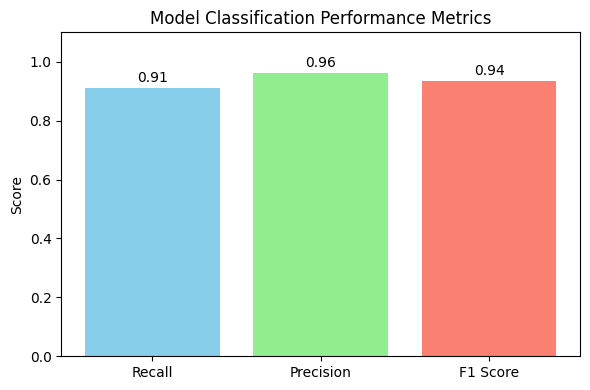

In [ ]:
metrics = ['Recall', 'Precision', 'F1 Score']
values = [recall, precision, f1]

plt.figure(figsize=(6, 4))
plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1.1)
plt.title('Model Classification Performance Metrics')
plt.ylabel('Score')
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.savefig("figures/recall-precision-f1score.png", dpi=300)
plt.show()

# Mean Average Precision for Localisation

2 Implementations
> 2nd function used for publishing results in the paper.

In [ ]:
def find_mAP_hard(dataloader, class_threshold, model):
    model.eval()
    all_confidence = []
    num_trues = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            images = images.permute(0, 3, 1, 2)
            predictions = model(images).detach().cpu()

            predictions = predictions.view(-1, predictions.shape[-1])
            trues = labels.view(-1, labels.shape[-1])

            num_trues += torch.sum(trues[:, 2] == 1).item()

            for i in range(predictions.shape[0]):
                    pred_x, pred_y, pred_class_conf = predictions[i]
                    true_x, true_y, true_class_conf = trues[i]
                    
                    if pred_class_conf >= class_threshold:
                        if true_class_conf == 1:
                            pred_coord = torch.tensor([pred_x, pred_y])
                            true_coord = torch.tensor([true_x, true_y])
            
                            d = torch.sqrt(torch.sum((pred_coord - true_coord) ** 2, dim=-1))
                            confidence = 1 - torch.sigmoid(69 * (d - 0.1))
                            all_confidence.append(confidence)
            
    dist_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    APs = []

    for dist_threshold in dist_thresholds:
        TP = []
        FP = []
        
        for confidence in all_confidence:
            if confidence >= dist_threshold:
                TP.append(1)
                FP.append(0)
            else:
                TP.append(0)
                FP.append(1)
    
        TP_cum = np.cumsum(TP)
        FP_cum = np.cumsum(FP)
        
        precisions = TP_cum / (TP_cum + FP_cum + 1e-6)
        recalls = TP_cum / num_trues
    
        AP = np.trapezoid(precisions, recalls)
        APs.append(AP)

    return sum(APs) / len(APs)

In [ ]:
def find_mAP_hard2(dataloader, class_threshold, model):
    model.eval()
    dist_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    APs = []
    
    for dist_threshold in dist_thresholds:
        all_detections = []
        num_trues = 0
        for images, labels in dataloader:
            images = images.to(device)
            images = images.permute(0, 3, 1, 2)
            predictions = model(images).detach().cpu()

            # batch size is one, so no need to worry
            predictions = predictions.view(-1, predictions.shape[-1])
            trues = labels.view(-1, labels.shape[-1])
            taken_trues = [False] * trues.shape[0]

            num_trues += torch.sum(trues[:, 2] == 1).item()
            predictions = predictions[predictions[:, -1].argsort(descending=True)]
            
            for i in range(predictions.shape[0]):
                pred_x, pred_y, pred_conf = predictions[i]
                if pred_conf >= class_threshold:
                    closest_idx = -1
                    closest_distance = torch.inf
                    for j in range(trues.shape[0]):
                        true_x, true_y, true_conf = trues[j]
                        if true_conf >= 0.5:
                            pred_coord = torch.tensor([pred_x, pred_y])
                            true_coord = torch.tensor([true_x, true_y])
            
                            dist = torch.sqrt(torch.sum((pred_coord - true_coord) ** 2, dim=-1))
                            if dist < closest_distance:
                                closest_distance = dist
                                closest_idx = j
                    
                    dist_conf = 1 - torch.sigmoid(69 * (closest_distance - 0.1))
                    if closest_idx != -1 and not taken_trues[closest_idx] and dist_conf >= dist_threshold:
                        taken_trues[closest_idx] = True
                        all_detections.append((pred_conf.item(), 1, 0))
                    else:
                        all_detections.append((pred_conf.item(), 0, 1))
    
        all_detections.sort(key=lambda x: x[0], reverse=True)
        TP = [d[1] for d in all_detections]
        FP = [d[2] for d in all_detections]
        
        TP_cum = np.cumsum(TP)
        FP_cum = np.cumsum(FP)

        precisions = TP_cum / (TP_cum + FP_cum + 1e-6)
        recalls = TP_cum / (num_trues + 1e-6)
        AP = np.trapezoid(precisions, recalls)
        APs.append(AP)
    
    return sum(APs)/len(APs)


In [ ]:
print(find_mAP_hard(test_loader, 0.5, model))
print(find_mAP_hard2(test_loader, 0.5, model))

0.8797790492985401
0.8614977558046941
